<a href="https://colab.research.google.com/github/tewed/projects/blob/main/Paysim_Fraud/Paysim%20Anomaly%20Detection%20EDA%20and%20Prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/sharansalem/fraud-detection-eda-modelling

https://www.kaggle.com/tewedj/fraud-detection-paysim

https://www.kaggle.com/code/arjunjoshua/predicting-fraud-in-financial-payment-services

# **Ethical considerations**

*  Prior to beginning any analysis, we need to determine if there are any ethical issues that might arise, considering the project at hand.

*  In this instance, we are predicting whether or not a transaction is fraudulent.

*  The project as a whole, does not appear to target anything that might be considered unethical - you would like to prevent all people from having their money stolen (vs just a subgroup).  The data has also been anonymised and simulated, so investigating the outcomes for specific biases will be difficult.

*  I also believe that my analysis will have minimal risk of being adapted and used for nefarious purposes.

Considering this, I believe the analysis can go forward.


Links to take note of, that I can refer back to as and when needed during the analysis.
https://towardsdatascience.com/exploratory-data-analysis-eda-with-pyspark-on-databricks-e8d6529626b1

https://s3.amazonaws.com/assets.datacamp.com/blog_assets/PySpark_Cheat_Sheet_Python.pdf

https://s3.amazonaws.com/assets.datacamp.com/blog_assets/PySpark_SQL_Cheat_Sheet_Python.pdf

https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.html#pyspark.sql.DataFrame

## **Importing packages**

Something to note is that specific packages used in specific circumstances, might be imported down the line, else they will be noted in the comments

In [ ]:
import sys
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn as sklearn
import shap

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from functools import reduce


### Print all versions of packages used

In [ ]:
print("Python version:", sys.version)
print("pandas version:", pd.__version__)
print("seaborn version:", sns.__version__)
print("numpy version:", np.__version__)
print("matplotlib version:", matplotlib.__version__)
print("sklearn version:", sklearn.__version__)



Python version: 3.11.3 | packaged by Anaconda, Inc. | (main, Apr 19 2023, 23:46:34) [MSC v.1916 64 bit (AMD64)]
pandas version: 1.5.3
seaborn version: 0.12.2
numpy version: 1.24.3
matplotlib version: 3.7.1
sklearn version: 1.2.2


# Set options for packages imported


In [ ]:
# Set options for packages imported
sns.set_style('darkgrid')
plt.style.use('seaborn-v0_8-colorblind')
sns.set(font_scale = 1.25)

#The same seed be used for all randomisation
seed = 1234
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

## Importing of dataset

In [ ]:
# Import using pandas to read the CSV file

df = pd.read_csv('Datasets\\PS_20174392719_1491204439457_log.csv')

In [ ]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0


#### Anonymisation
Looking at the data, we can see that it has been anonymized as described in the metadata.

There is no clear indication of personal details of customers.

An ethical consideration, would have been whether or not you would have the opportunity (albeit inadvertantly) to build a model that discriminates based on age, gender, race or any other factor.  The anonimisation makes this difficult to impossible in this instance.  

The anonymisation does eliminate discrimination from a developer perspective, but certain characteristics in the data could still influence it (for instance - what if the particular product under investigation was only marketed in certain areas which has a higher population of certain ethnic groups)

In [ ]:
# Get data types of columns to see if the imported correctly
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [ ]:
# Rename the one column to be more consistent
df = df.rename(columns={"oldbalanceOrg" : "oldbalanceOrig"})

In [ ]:
# Dataframe dimensions to get an idea of the scale of the data
print(f"This dataframe has {len(df)} rows and {len(df.columns)} columns.")

This dataframe has 6362620 rows and 11 columns.


In [ ]:
# Check summary statistics, sending the result to pandas, to more neatly format it for viewing and comparison
df.describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
step,6362620.00,243.40,142.33,1.00,156.00,239.00,335.00,743.00
amount,6362620.00,179861.90,603858.23,0.00,13389.57,74871.94,208721.48,92445516.64
oldbalanceOrig,6362620.00,833883.10,2888242.67,0.00,0.00,14208.00,107315.18,59585040.37
newbalanceOrig,6362620.00,855113.67,2924048.50,0.00,0.00,0.00,144258.41,49585040.37
oldbalanceDest,6362620.00,1100701.67,3399180.11,0.00,0.00,132705.66,943036.71,356015889.35
newbalanceDest,6362620.00,1224996.40,3674128.94,0.00,0.00,214661.44,1111909.25,356179278.92
isFraud,6362620.00,0.00,0.04,0.00,0.00,0.00,0.00,1.00
isFlaggedFraud,6362620.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00


There appears to be some outlying values for various fields, I would like to investigate how skew the data is as well.

In [ ]:
# Look for any missing values in the data
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrig    0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

**No Missing values**, which is great - this means it is not something we need to deal with.

As a first step, I want to add a feature that shows me whether or not a Merchant was part of the transaction, as I would like to use that in my profiling of the data.  This could be important in identifying fraudulent transactions.

*Although this and some other derivations constitute part of **feature engineering** implemented later on, it is something I am doing here, as I already believe it could be an important part of the EDA*.

I create an indicator variable showing whether a merchant was part of the transaction either as the Origin, Destination or either of it.

In [ ]:
df['merchOrig'] = (df['nameOrig'].str.strip().str.slice(0,1) == 'M').astype(int)
df['merchDest'] = (df['nameDest'].str.strip().str.slice(0,1) == 'M').astype(int)
df['merchInvolved'] = df[["merchOrig", "merchDest"]].max(axis=1)
df.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0,1,1
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0,1,1
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0,0,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0,1,1


I also want to include a measure for the **HOUR** of the day on which the transaction occurred.

Looking at the description of the data, the STEP field is related to the hour of the transaction within the month, so we could get the hour of the day a transaction occurred using this.

Using this information, I add the hour of the day into a feature called "txn_hour".

In [ ]:
df['txn_hour'] = df['step'] % 24
df.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0,1,1,1
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0,1,1,1
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0,0,0,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,0,0,0,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0,1,1,1


##### Wishlist item:

All of the transactions occur only over a 1 month period, so getting the day of the month wont be relevant here, although day of the week would be something I would want to look at as well.  I dont believe that will bear fruit in this case, as the data is only for a single month. If the data was available for a period of 6 months, this would definitely be a feature I would include.

# Exploratory analysis

I want to see the distribution of transaction types to get an understanding of how the data looks, over and above the basic stats I looked at previously.

Start by looking at the distribution of transaction types in the data, as that is one of the standout categorical fields in the data:

Ignoring `palette` because no `hue` variable has been assigned.


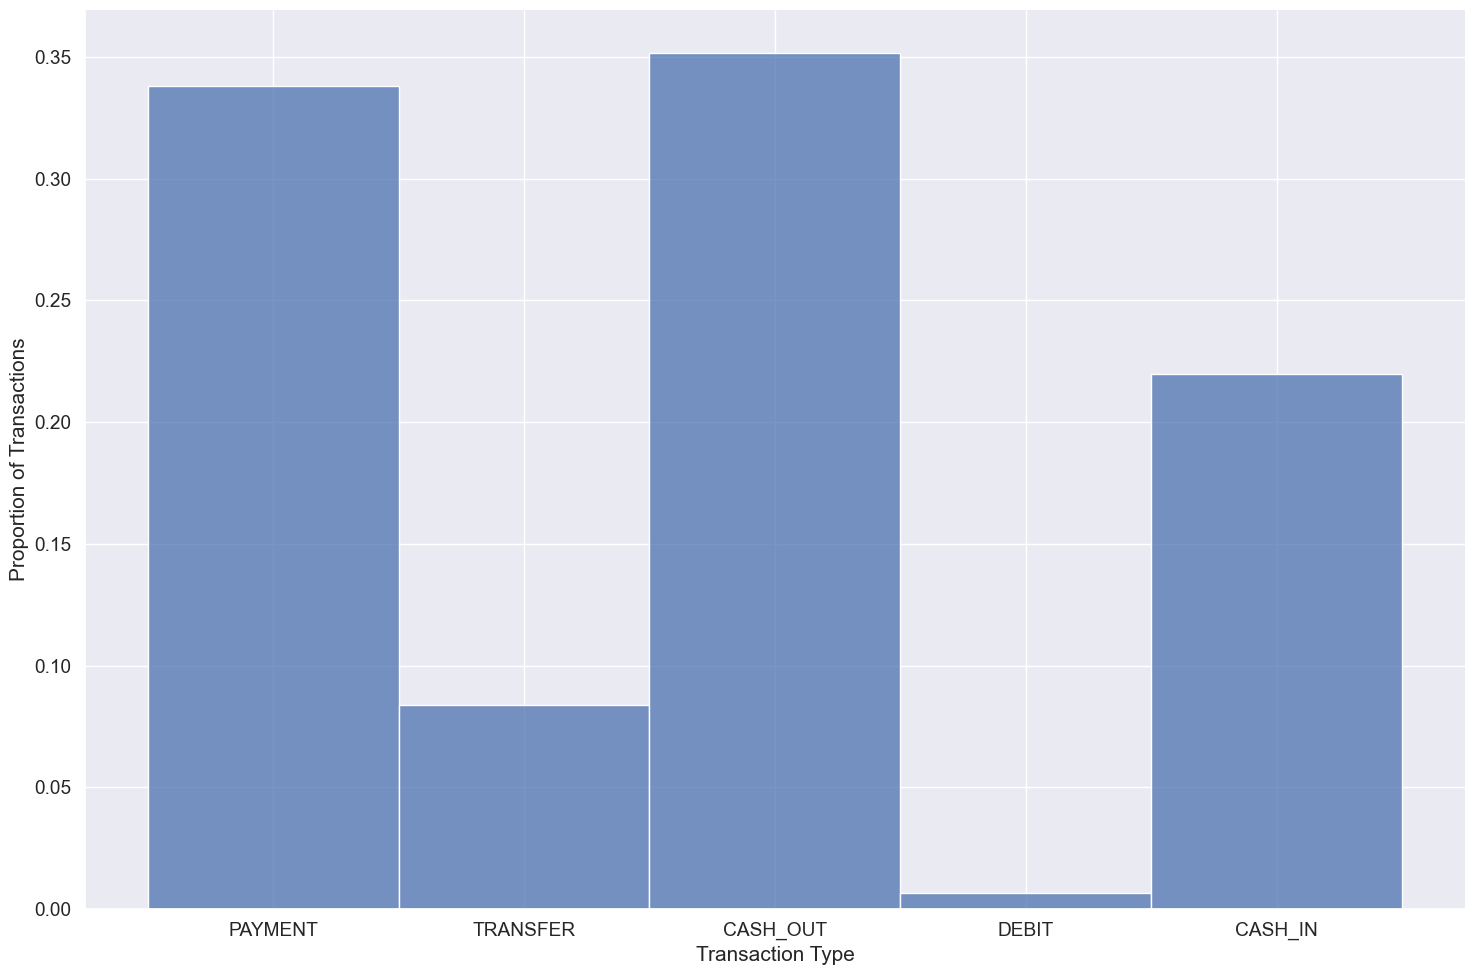

In [ ]:
fig = sns.displot(data=df, x='type', stat='probability', height=10, aspect=1.5,palette = 'colorblind')
fig.set_axis_labels('Transaction Type', 'Proportion of Transactions')

The Majority of the Transactions are PAYMENT (34%) and CASH_OUT (35%) transactions.

DEBIT transactions are by far the least (~1%).

Considering that, how does this distribution compare to the Fraudulent transaction types that occured?

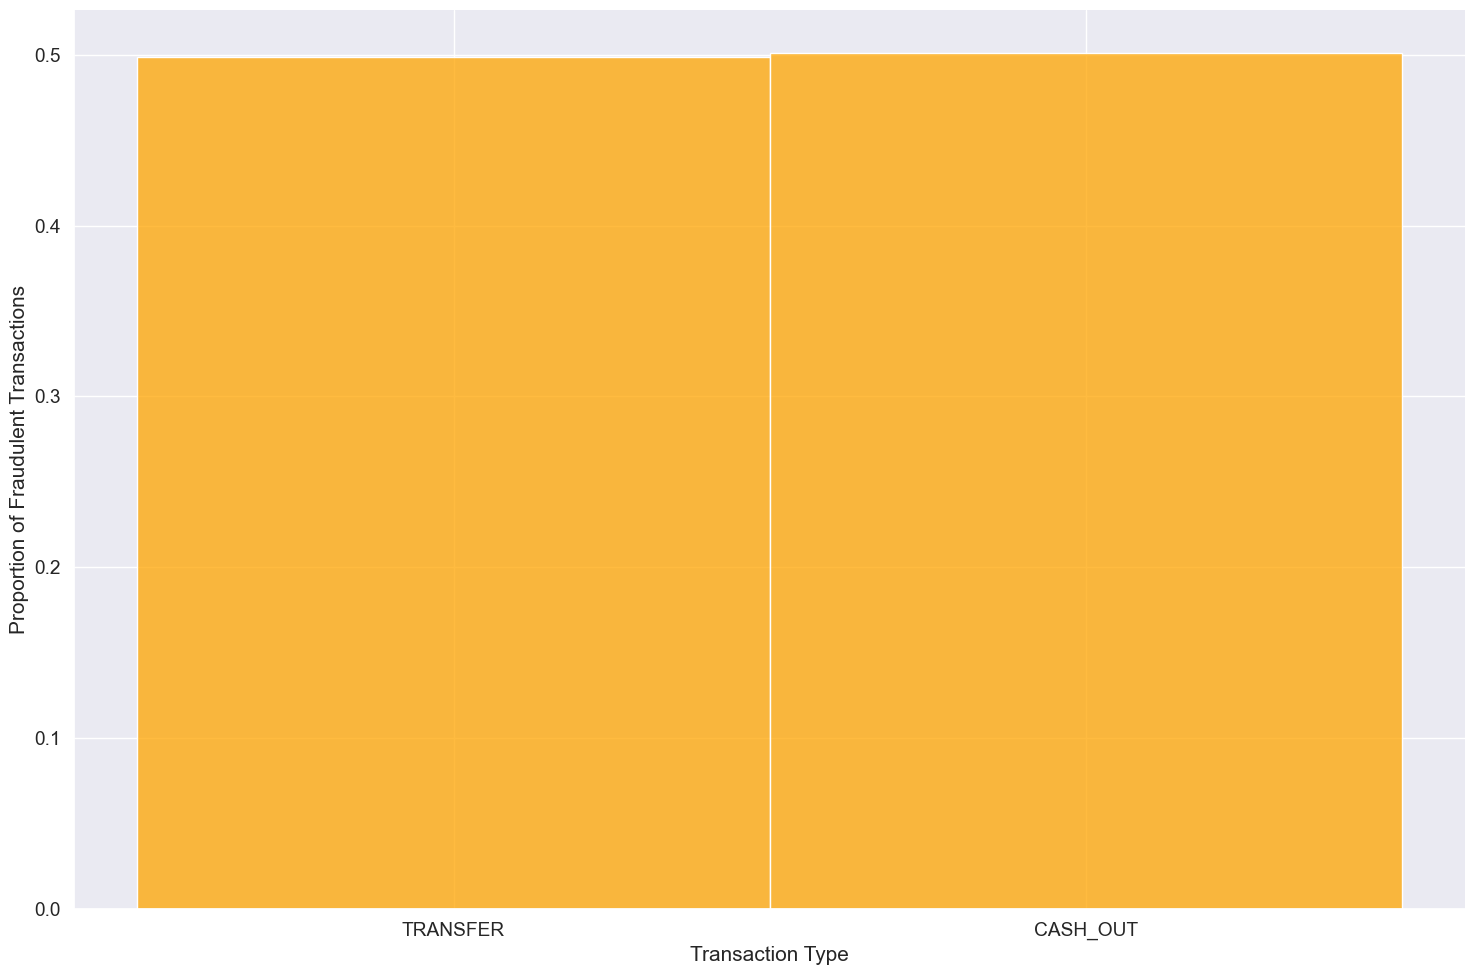

In [ ]:
fig = sns.displot(data=df[df['isFraud'] == 1],
                  x='type', stat='probability', height=10, aspect=1.5, color='orange')
fig.set_axis_labels('Transaction Type', 'Proportion of Fraudulent Transactions')

The _only_ Fraudulent transactions are _Transfer and Cash Out_, with roughly equal amounts of each being made.

With "type" being a categorical variable - I want to see some descriptive statistics around the value of the transactions for each category.

I like to view **percentiles**, as it will also give an indication on whether or not there are any outliers present.

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df.describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).transpose().round(2)

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
step,6362620.00,243.40,142.33,1.00,9.00,16.00,156.00,239.00,335.00,490.00,681.00,743.00
amount,6362620.00,179861.90,603858.23,0.00,449.47,2224.10,13389.57,74871.94,208721.48,518634.20,1615979.47,92445516.64
oldbalanceOrig,6362620.00,833883.10,2888242.67,0.00,0.00,0.00,0.00,14208.00,107315.18,5823702.28,16027256.13,59585040.37
newbalanceOrig,6362620.00,855113.67,2924048.50,0.00,0.00,0.00,0.00,0.00,144258.41,5980262.34,16176160.56,49585040.37
oldbalanceDest,6362620.00,1100701.67,3399180.11,0.00,0.00,0.00,0.00,132705.66,943036.71,5147229.71,12371819.15,356015889.35
newbalanceDest,6362620.00,1224996.40,3674128.94,0.00,0.00,0.00,0.00,214661.44,1111909.25,5515715.90,13137866.94,356179278.92
isFraud,6362620.00,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
isFlaggedFraud,6362620.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
merchOrig,6362620.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
merchDest,6362620.00,0.34,0.47,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00


In [ ]:
# set some display options to format output
pd.set_option('display.max_rows', 500)
df[['type','amount','oldbalanceOrig','newbalanceOrig','oldbalanceDest','newbalanceDest']].groupby('type').describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).transpose().round(2)



type                      CASH_IN     CASH_OUT        DEBIT     PAYMENT  \
amount         count   1399284.00   2237500.00     41432.00  2151495.00   
               mean     168920.24    176273.96      5483.67    13057.60   
               std      126508.26    175329.74     13318.54    12556.45   
               min           0.04         0.00         0.55        0.02   
               1%         2999.74      3108.00        68.53      176.19   
               5%        14552.34     15266.73       324.67      871.69   
               25%       70510.18     72669.65      1500.18     4383.82   
               50%      143427.71    147072.18      3048.99     9482.19   
               75%      239899.09    246539.48      5479.18    17561.22   
               95%      412005.13    427877.16     14795.35    37835.66   
               99%      550870.86    579654.07     50817.98    59500.11   
               max     1915267.90  10000000.00    569077.51   238637.98   
oldbalanceOrig count   1399284.00   2237500.00     41432.00  2151495.00   
               mean    3590463.51     46023.80     68647.34    68216.83   
               std     5291824.90    179132.64    138449.28   198991.08   
               min           0.00         0.00         0.00        0.00   
               1%            9.00         0.00         0.00        0.00   
               5%          787.00         0.00         0.00        0.00   
               25%       37768.00         0.00      1518.50        0.00   
               50%     1200093.32       556.00     20821.11    10530.00   
               75%     5284254.75     31446.24     68806.61    60883.00   
               95%    15237053.40    229226.76    311319.28   337181.03   
               99%    24397493.97    582650.01    655636.08   690936.64   
               max    38939424.03  43818855.30   4362014.11 43686616.33   
newbalanceOrig count   1399284.00   2237500.00     41432.00  2151495.00   
               mean    3759378.71     17474.19     65161.65    61837.89   
               std     5287487.26    109194.04    137656.58   196991.52   
               min           5.44         0.00         0.00        0.00   
               1%        24033.60         0.00         0.00        0.00   
               5%        69730.52         0.00         0.00        0.00   
               25%      249756.87         0.00         0.00        0.00   
               50%     1369114.92         0.00     16632.42        0.00   
               75%     5450490.53         0.00     62630.80    49654.13   
               95%    15391933.43     94301.90    306820.25   324460.74   
               99%    24554705.15    417293.04    649605.15   676816.25   
               max    38946233.02  43686616.33   4359375.18 43673802.21   
oldbalanceDest count   1399284.00   2237500.00     41432.00  2151495.00   
               mean    1587918.80   1497757.89   1493135.77        0.00   
               std     3713923.25   3633876.46   4386970.30        0.00   
               min           0.00         0.00        85.00        0.00   
               1%            0.00         0.00      6077.05        0.00   
               5%            0.00         0.00     20139.30        0.00   
               25%      161260.78    114685.93    130025.08        0.00   
               50%      547137.31    488098.50    424460.41        0.00   
               75%     1619594.28   1510450.46   1372974.62        0.00   
               95%     6511854.71   6246391.68   6249230.50        0.00   
               99%    13940349.48  13525912.09  13767837.54        0.00   
               max   355553416.30 356015889.35 327827763.42        0.00   
newbalanceDest count   1399284.00   2237500.00     41432.00  2151495.00   
               mean    1467105.39   1691326.07   1513003.47        0.00   
               std     3712985.25   3663007.57   4395708.01        0.00   
               min           0.00         0.00         0.00        0.00   
               1%        

In [ ]:
pd.set_option('display.max_rows', 15)

From the above, I can also see that TRANSFER and CASH_OUT transactions had the highest _median_ and _Maximum_ transaction values.

There appears to be **outlying** transaction amounts with all of the transaction types.  This is something I would normally deal with later on, should I want to use a model that is sensitive to outliers.  For now, it is not sometihng I am catering for.

I would consider *capping* the outliers at the 95th or 99th percentile, or removing the outlying records completely, depending on whether they are found as part of a Fraudulent transaction.   

If the outliers are part of a Fraudulent transaction, I would consider adding a binary variable as well to indicate that it is an Outlying amount, along with capping the amount - this is due to the fact that it is outlying, might be relevant with regards to being Fraudulent.

Considering 2 of the main features I created (txn_hour and merchInvolved), how do they relate to the transaction being fraudulent?

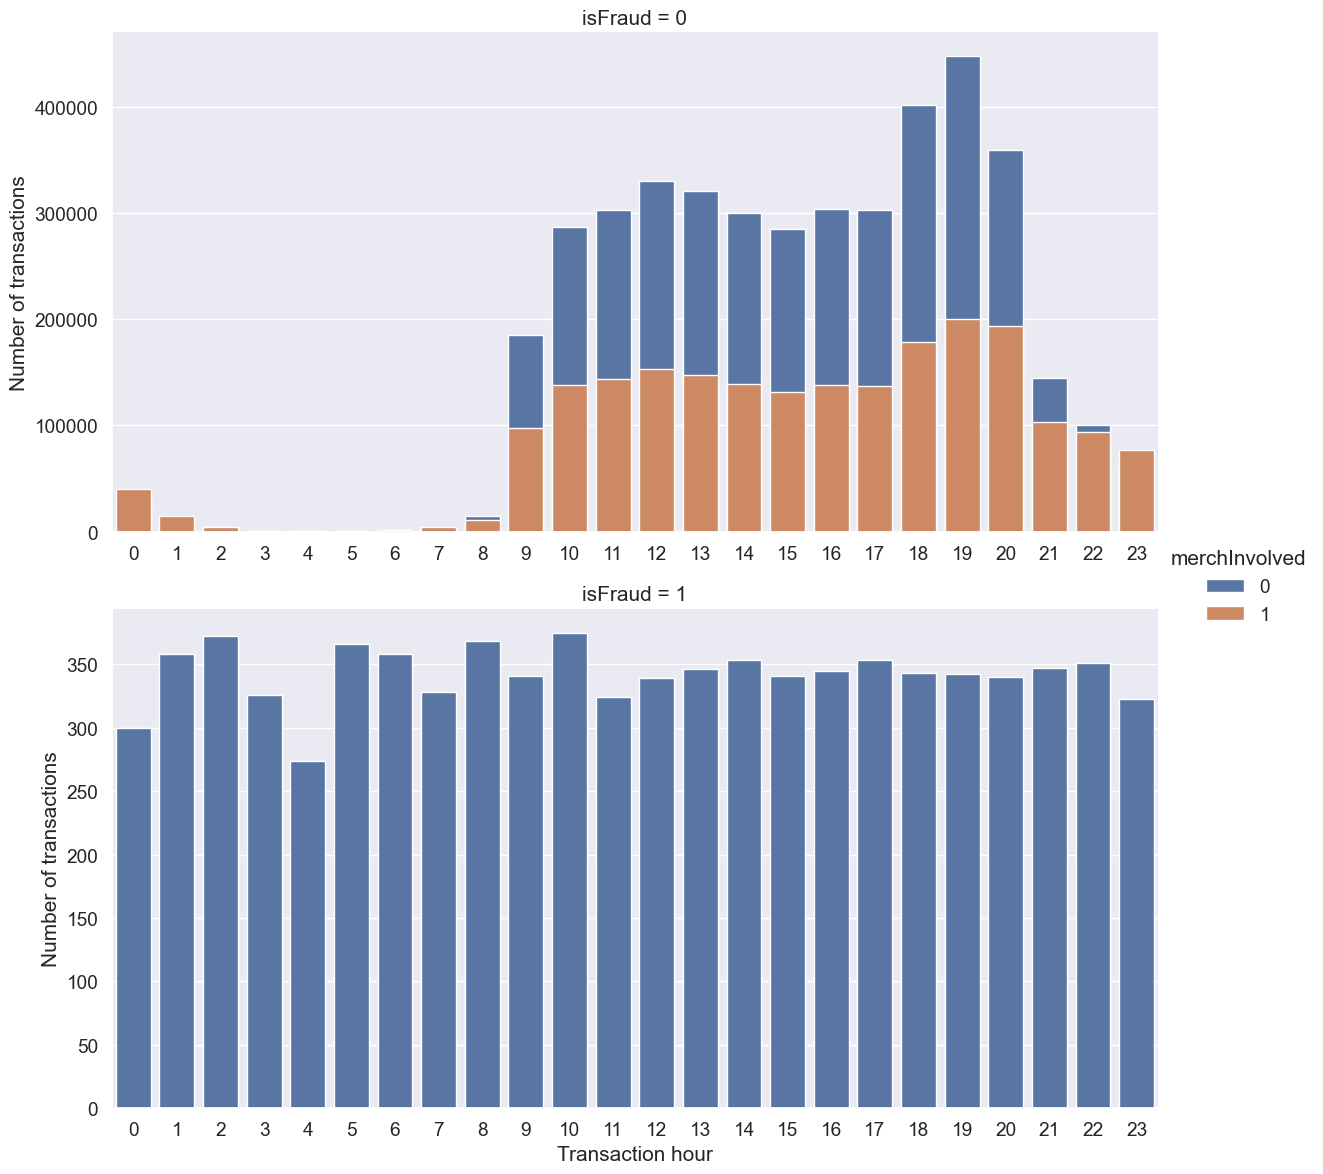

In [ ]:
ax = sns.catplot(kind='bar',
            data=df.groupby(['txn_hour', 'merchInvolved', 'isFraud'])
                        .size().reset_index()
           , x='txn_hour'
           , y = 0
           , row ='isFraud'
           , hue='merchInvolved'
           , dodge=False
           , height=6
           , aspect=2
           , sharey=False
           ,sharex=False)
ax.set_xlabels('Transaction hour', fontsize=15 )
ax.set_ylabels('Number of transactions', fontsize=15 )

Between 09:00 and 20:00, there are more transactions that do not involve a merchant, other times merchant transactions start picking up.

_None of the Fraudulent transactions had a Merchant involved in them, which makes sense as merchants would likely not commit fraud directly on their clients_

Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.


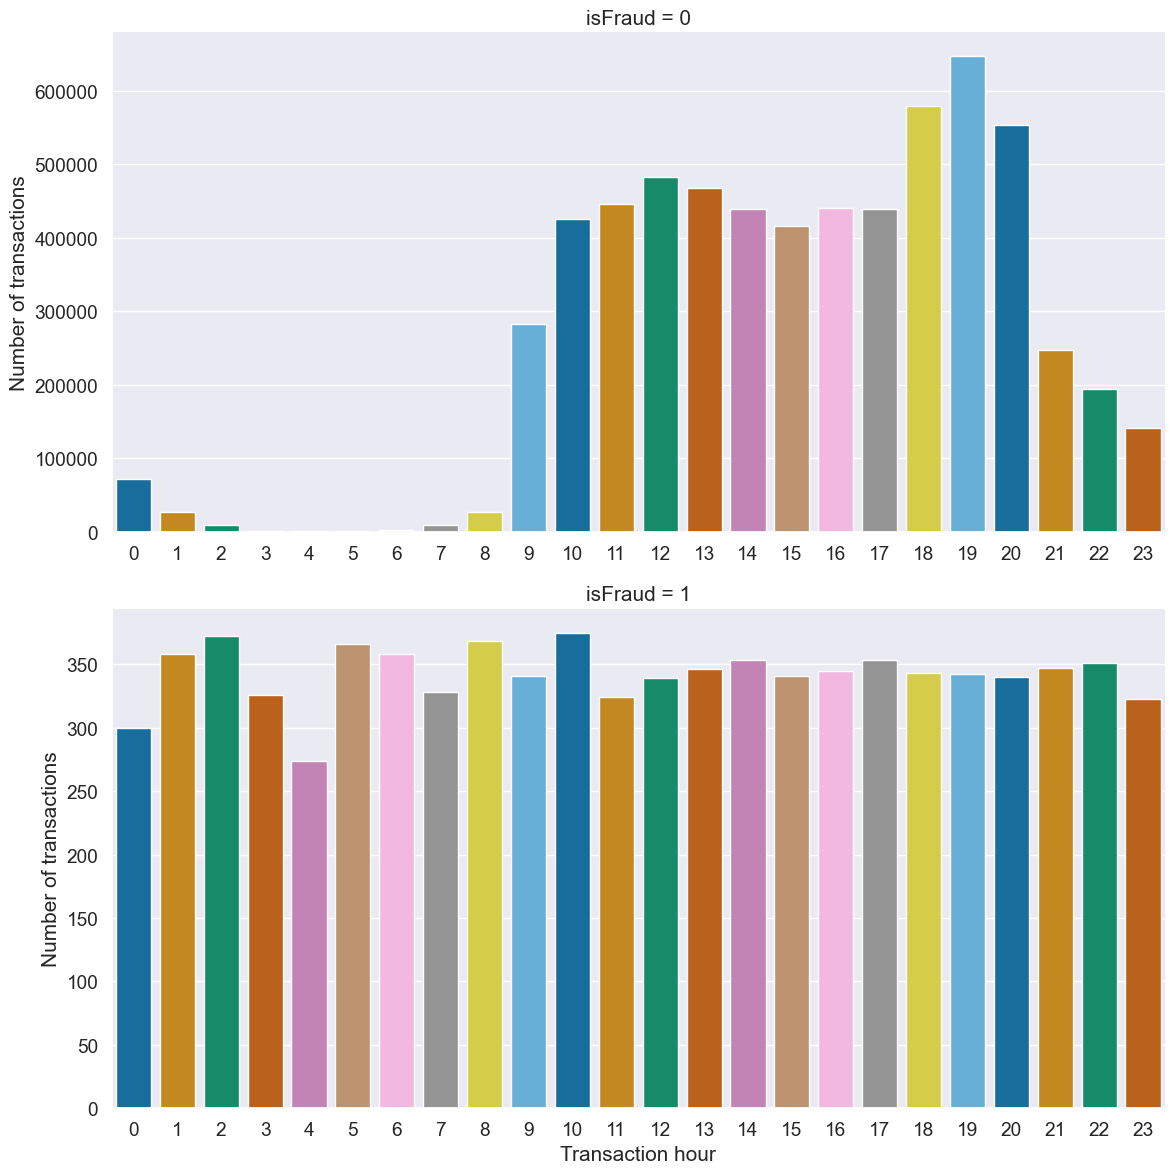

In [ ]:
hour_vs_fraud = sns.catplot(  kind  ='count'
            , x     ="txn_hour"
            , row   ='isFraud'
            , data  =df
            , sharey=False
            , height=6
            , aspect=2
            , palette = 'colorblind'
            ,sharex=False
           )
hour_vs_fraud.set_xlabels('Transaction hour')
hour_vs_fraud.set_ylabels('Number of transactions')

plt.show()

The majority of transactions happen between 09:00 and 19:00 during the day. With some of them after hours.

Fraudulent transactions are _relatively evenly_ distributed across the day, with no clear peak value, although there is a higher proportion of fraudulent transactions occur between 2:00 and 7:00 in the morning, due to the reduction in overall number of transactions during those hours

What does the average transaction amount look like per hour?

Text(0, 0.5, 'Avg. transaction amount (millions)')

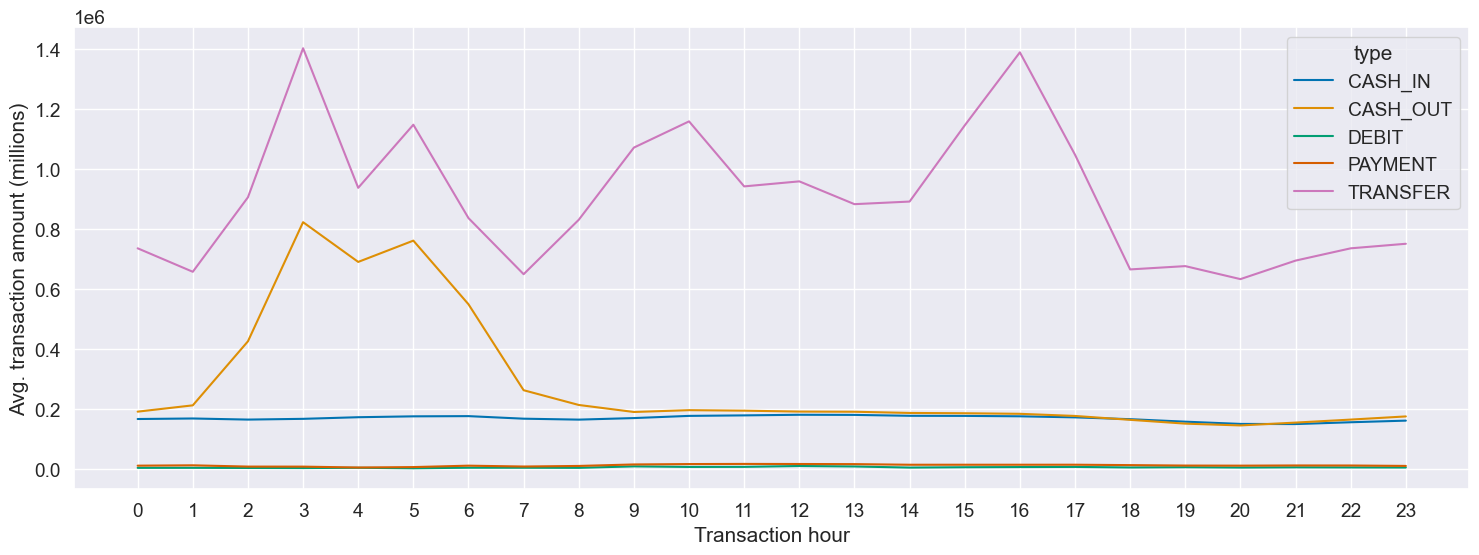

In [ ]:
# Need to get the average amount per hour and plot that,
# per transaction type and split for fraud vs non-fraud
plt.figure(figsize=(18,6))
sns.lineplot(data=df.groupby(['txn_hour','type'])
                 .agg({'amount' : 'mean'})
                 .reset_index(),
             x='txn_hour',
             y='amount',
             hue='type',
             palette='colorblind'
           )
plt.xlabel('Transaction hour', fontsize=15 )
plt.xticks(range(24), range(24))
plt.ylabel('Avg. transaction amount (millions)', fontsize=15)

It is a bit hard to see the values for CASH_IN, DEBIT and PAYMENT, due to them being so small compared to the rest, so  I split them out and plot seperately.

Text(0, 0.5, 'Avg. transaction amount')

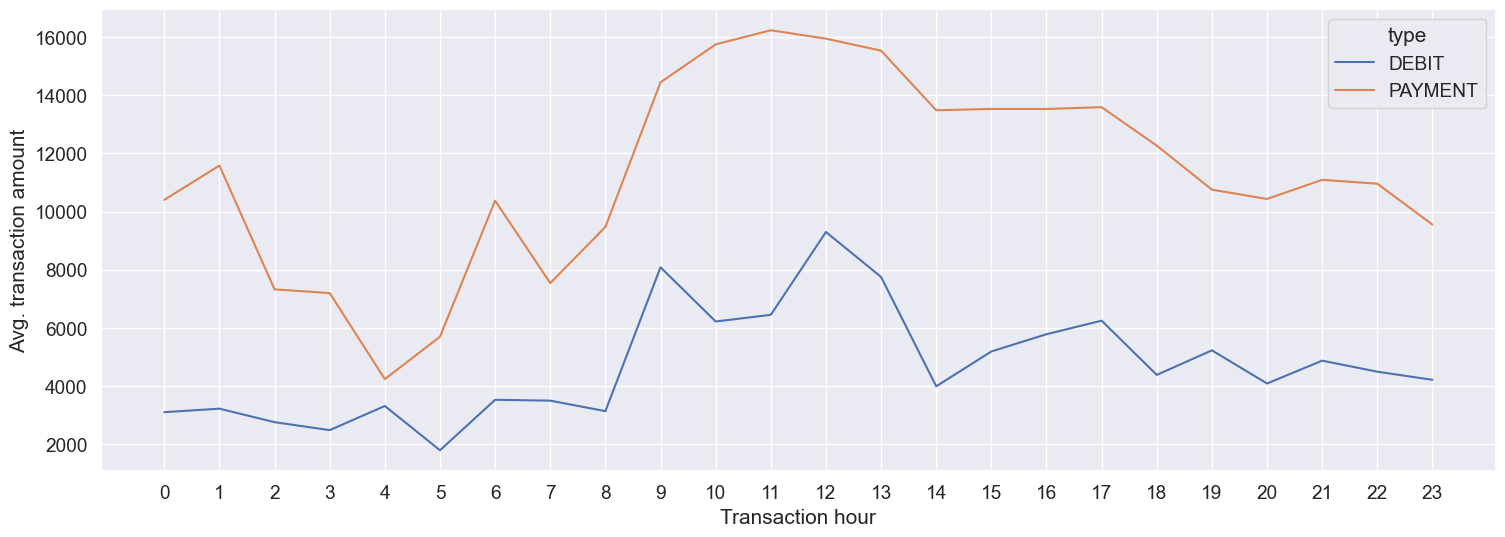

In [ ]:
# Check for the ones we couldnt make out in the above graph
plt.figure(figsize=(18,6))
sns.lineplot(data=df[df['type']
                        .isin(['DEBIT','PAYMENT'])]
                 .groupby(['txn_hour','type'])
                 .agg({'amount' : 'mean'})
                 .reset_index(),
             x='txn_hour',
             y='amount',
             hue='type')
plt.xlabel('Transaction hour', fontsize=15 )
plt.xticks(range(24), range(24))
plt.ylabel('Avg. transaction amount', fontsize=15)

CASH OUTS tend to happen early morning (between 03:00 and 05:00), while TRANSFERS peak very early morning (03:00), and again at 16:00

DEBITS and PAYMENTS peak between 09:00 and 13:00 during the day

What about the parties involved in the transactions? Is there a difference in times throughout the day?

Lets look at the distribution of the various balances for both origination and destination accounts.

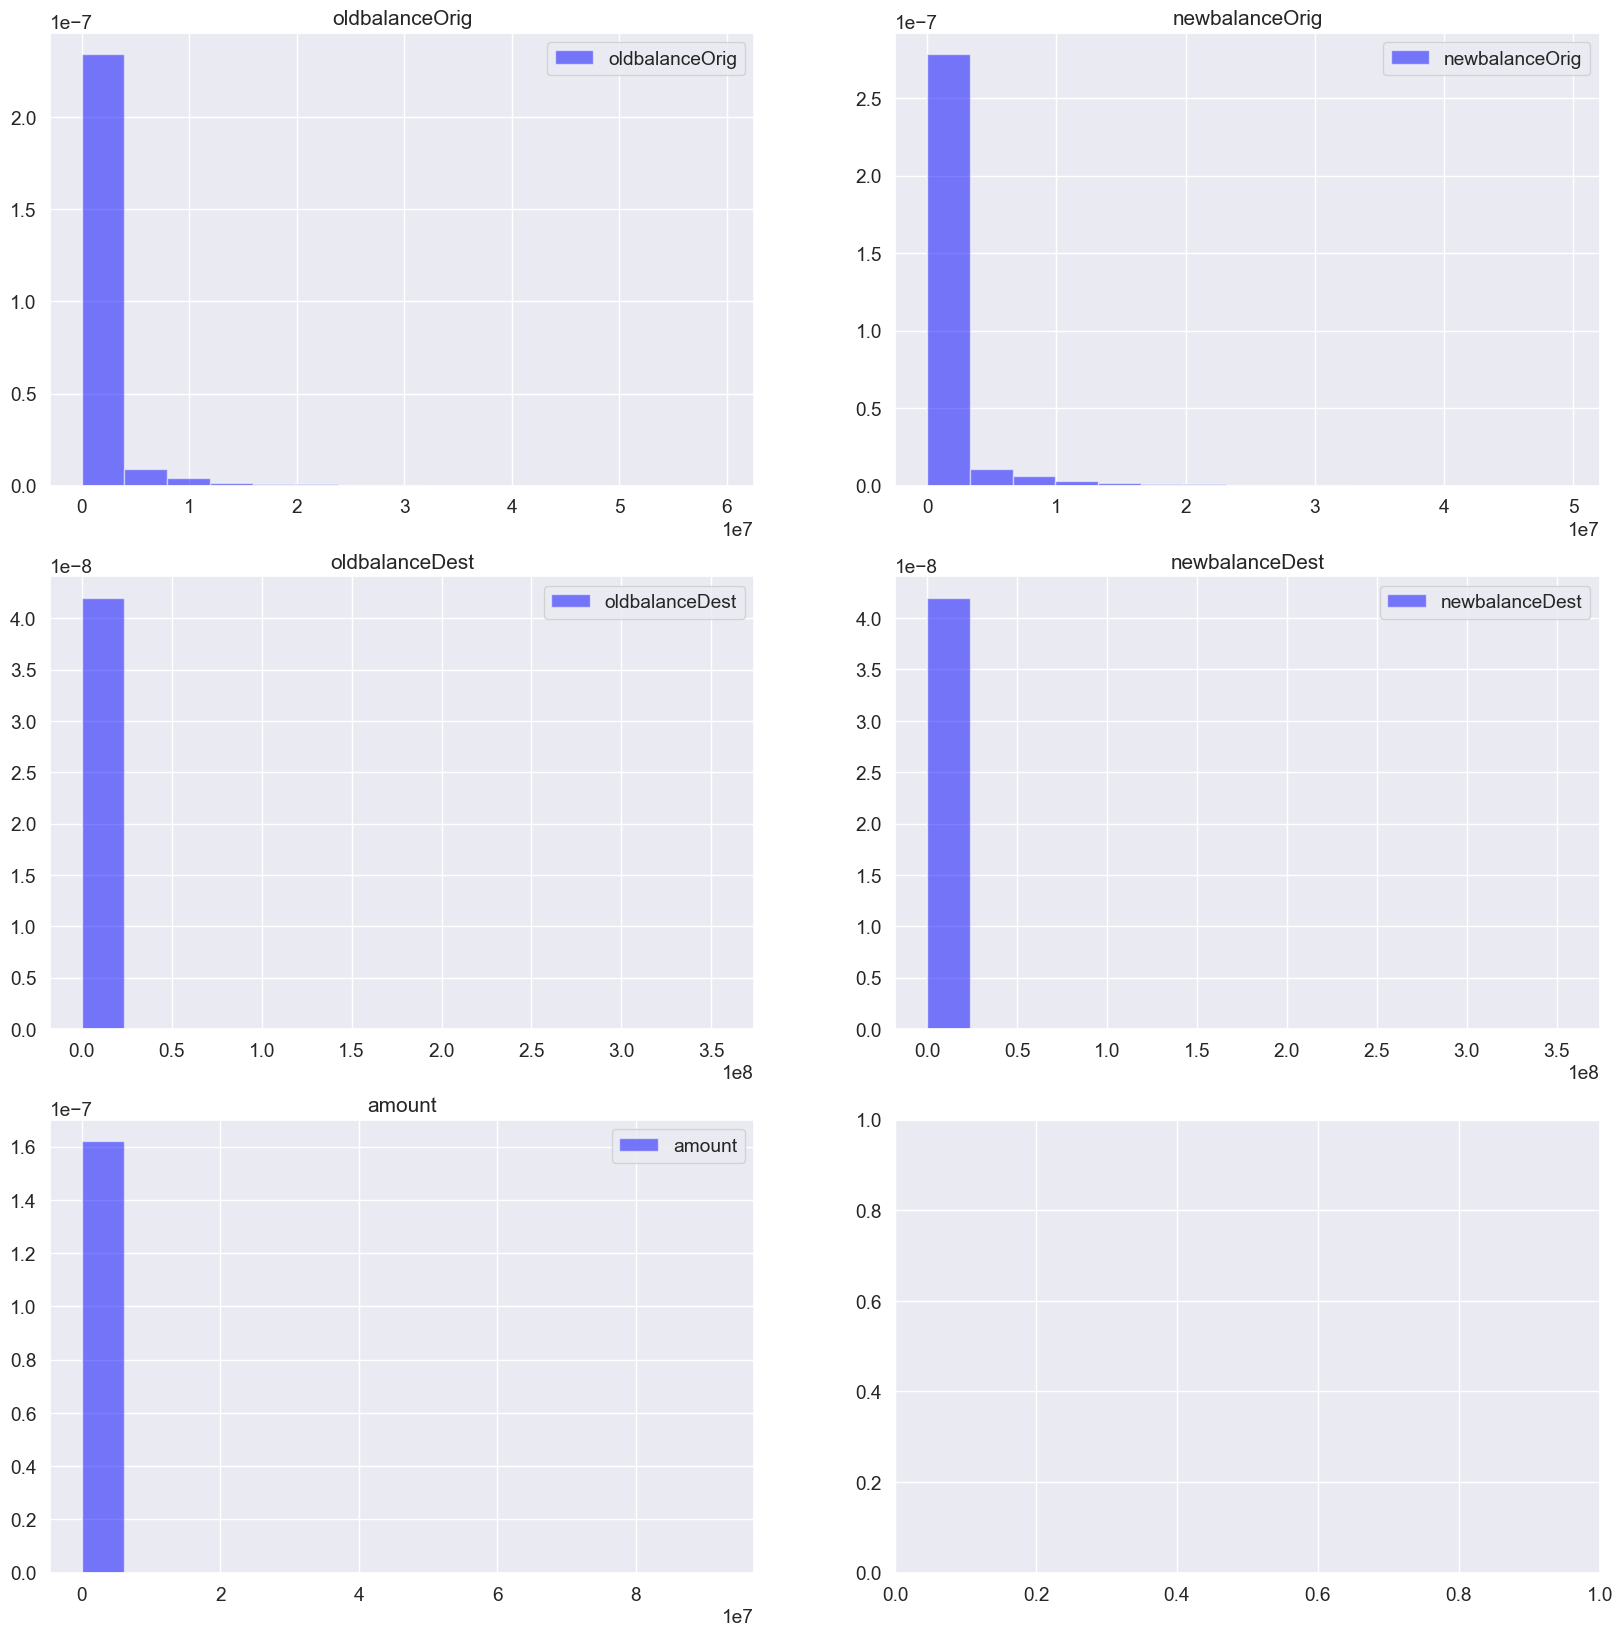

In [ ]:
bins=15
fig, axs = plt.subplots(3,2,figsize=(20, 20), sharey = False)

axs[0, 0].hist(df['oldbalanceOrig'], bins=bins, color='blue', alpha=0.5, label='oldbalanceOrig', density=True)
axs[0, 0].set_title('oldbalanceOrig')
axs[0, 0].legend()

axs[0, 1].hist(df['newbalanceOrig'], bins=bins, color='blue',
               alpha=0.5, label='newbalanceOrig', density=True)
axs[0, 1].set_title('newbalanceOrig')
axs[0, 1].legend()

axs[1, 0].hist(df['oldbalanceDest'], bins=bins, color='blue', alpha=0.5, label='oldbalanceDest', density=True)
axs[1, 0].set_title('oldbalanceDest')
axs[1, 0].legend()

axs[1, 1].hist(df['newbalanceDest'], bins=bins, color='blue', alpha=0.5, label='newbalanceDest', density=True)
axs[1, 1].set_title('newbalanceDest')
axs[1, 1].legend()

axs[2, 0].hist(df['amount'], bins=bins, color='blue', alpha=0.5, label='amount', density=True)
axs[2, 0].set_title('amount')
axs[2, 0].legend()



Most of these data points are _very skewed_ as we saw before when looking at the statistics.

I want to display the data without the massive skewness I see in there, so I am applying a _log transformation_ on everything I plot.

I also split the data for fraud vs non-fraud to see if there are differences in the distributions between the 2 sets.

In [ ]:
# Create a fraud dataframe and a non-fraud dataframe
df_fraud    = df[df['isFraud'] == 1]
df_nonfraud = df[df['isFraud'] == 0]

df_nonfraud.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0,1,1,1
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0,1,1,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0,1,1,1
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.00,0.00,0,0,0,1,1,1
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.00,0.00,0,0,0,1,1,1


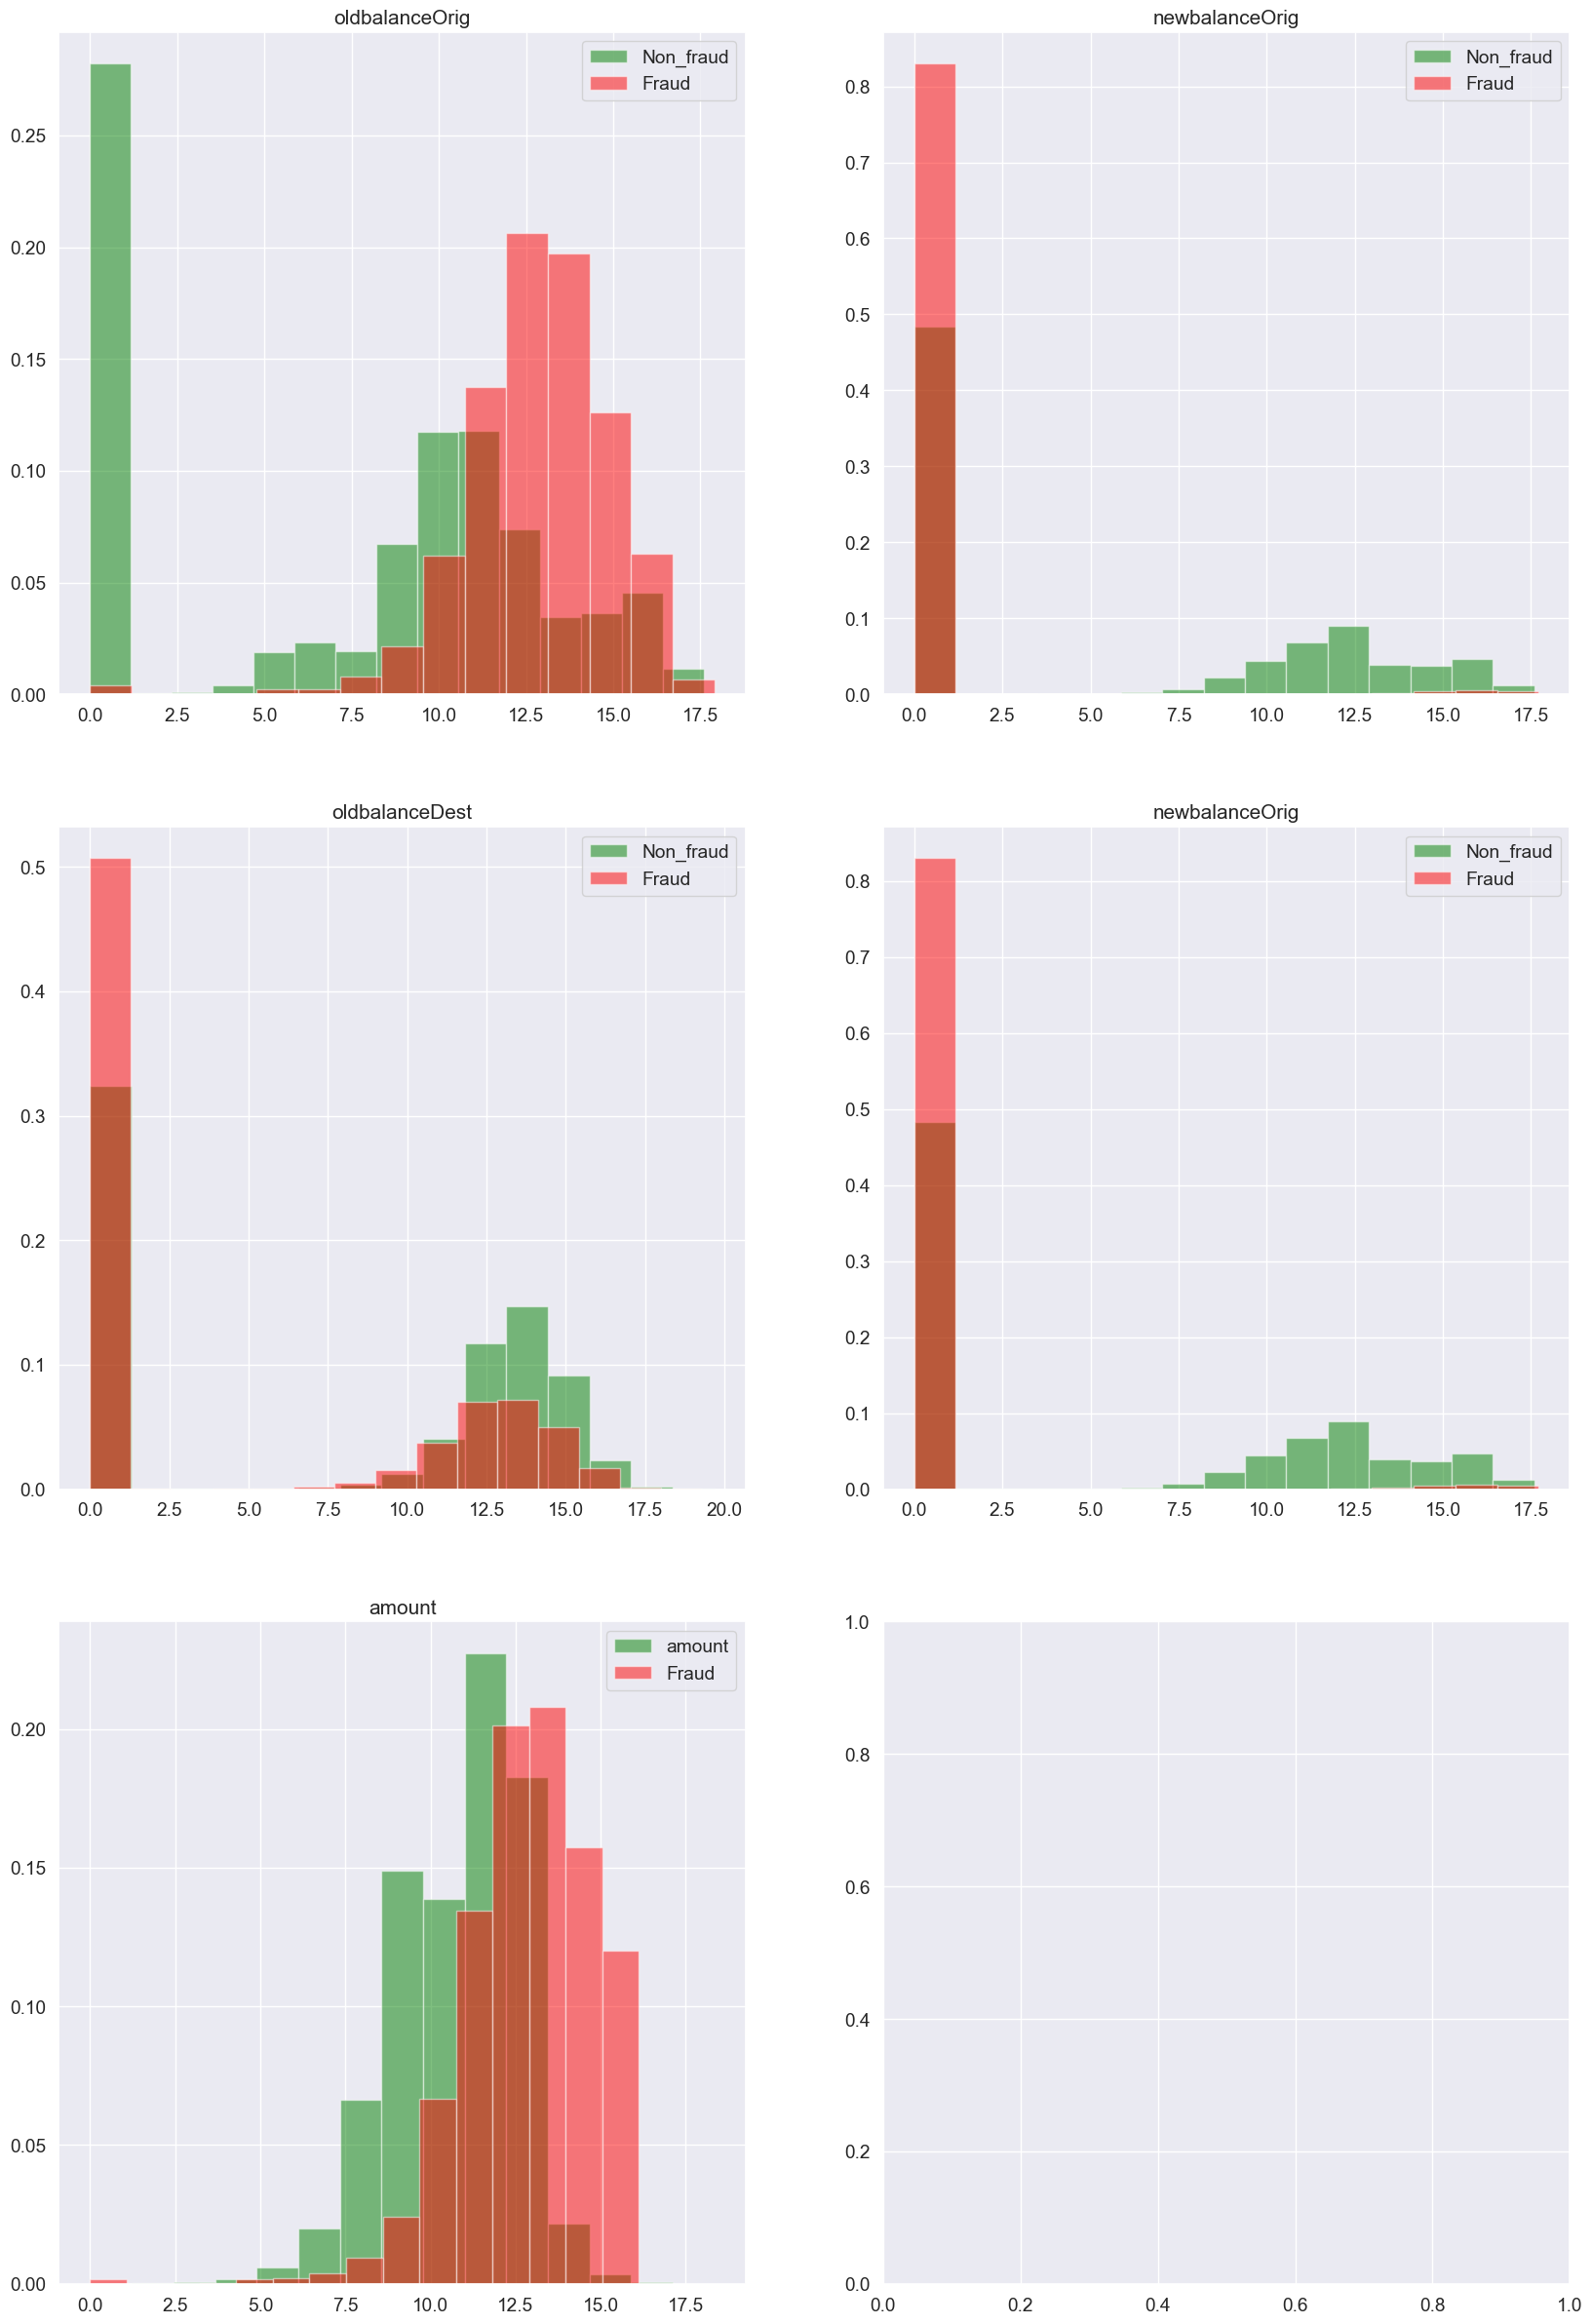

In [ ]:
fig, axs = plt.subplots(3,2,figsize=(20, 30), sharey = False)

axs[0, 0].hist((df_nonfraud['oldbalanceOrig'] + 1).apply(np.log), bins=bins, color='green', alpha=0.5, label='Non_fraud', density=True)
axs[0, 0].hist((df_fraud['oldbalanceOrig'] + 1).apply(np.log), bins=bins, color='red', alpha=0.5, label='Fraud', density=True)
axs[0, 0].set_title('oldbalanceOrig')
axs[0, 0].legend()

axs[0, 1].hist((df_nonfraud['newbalanceOrig'] + 1).apply(np.log), bins=bins, color='green', alpha=0.5, label='Non_fraud', density=True)
axs[0, 1].hist((df_fraud['newbalanceOrig'] + 1).apply(np.log), bins=bins, color='red', alpha=0.5, label='Fraud', density=True)
axs[0, 1].set_title('newbalanceOrig')
axs[0, 1].legend()

axs[1, 0].hist((df_nonfraud['oldbalanceDest'] + 1).apply(np.log), bins=bins, color='green', alpha=0.5, label='Non_fraud', density=True)
axs[1, 0].hist((df_fraud['oldbalanceDest'] + 1).apply(np.log), bins=bins, color='red', alpha=0.5, label='Fraud', density=True)
axs[1, 0].set_title('oldbalanceDest')
axs[1, 0].legend()

axs[1, 1].hist((df_nonfraud['newbalanceOrig'] + 1).apply(np.log), bins=bins, color='green', alpha=0.5, label='Non_fraud', density=True)
axs[1, 1].hist((df_fraud['newbalanceOrig'] + 1).apply(np.log), bins=bins, color='red', alpha=0.5, label='Fraud', density=True)
axs[1, 1].set_title('newbalanceOrig')
axs[1, 1].legend()

axs[2, 0].hist((df_nonfraud['amount'] + 1).apply(np.log), bins=bins, color='green', alpha=0.5, label='amount', density=True)
axs[2, 0].hist((df_fraud['amount'] + 1).apply(np.log), bins=bins, color='red', alpha=0.5, label='Fraud', density=True)
axs[2, 0].set_title('amount')
axs[2, 0].legend()


Amounts are skewed to the right for fraudulent transactions - _fraudulent transactions appear to be of higher value_.

Also see that there is a lot of accounts that had a _0 balance AFTER the transaction occurred_, which indicates that fraudulent transactions tend to clear out the accounts.  I will definitely create a feature for it to be included.

Something I would like to check, is whether we have multiple transactions per Customer in the data.  

Due to it being simulated, it might not be.

In [ ]:
# How many unique originating and destination names are there?
# Dataframe dimensions to recap the observation count
print(f"This dataframe has {len(df)} rows. \n")

print("Number of unique nameOrig:", df['nameOrig'].nunique())
print("Number of unique nameDest:", df['nameDest'].nunique())

This dataframe has 6362620 rows. 

Number of unique nameOrig: 6353307
Number of unique nameDest: 2722362


There appear to be _multiple transactions_ per originating and destination client/merchant.  
Meaning we might be able to generate features on what happened PRIOR to a transaction happening for each client

In [ ]:
# How many transactions were there, for originating and destination accounts,
# When there are multiple?
df[['nameOrig', 'type']].groupby(['nameOrig']).count() \
                            .reset_index().sort_values(by='type', ascending=False) \
                            .rename(columns={"type": "count"}).head(10)

,nameOrig,count
213775,C1065307291,3
2575378,C1784010646,3
2964663,C1902386530,3
2735131,C1832548028,3
4857429,C545315117,3
1520460,C1462946854,3
3455282,C2051359467,3
4260723,C363736674,3
3207898,C1976208114,3
1742342,C1530544995,3


In [ ]:
df[['nameDest', 'type']].groupby(['nameDest']).count() \
                            .reset_index().sort_values(by='type', ascending=False) \
                            .rename(columns={"type": "count"}).head(10)

,nameDest,count
84652,C1286084959,113
567820,C985934102,109
472721,C665576141,105
320660,C2083562754,102
349730,C248609774,101
174831,C1590550415,101
233498,C1789550256,99
409775,C451111351,99
106929,C1360767589,98
6969,C1023714065,97


There are definitely clients that had multiple transactions in the data, so _creating features to characterise their behaviour prior to a new transaction, could prove valuable_.

What about fraudulent transactions - are there clients that had multiple linked to them?

In [ ]:
df[df['isFraud'] == 1][['nameOrig', 'type']].groupby(['nameOrig']).count() \
                            .reset_index().sort_values(by='type', ascending=False) \
                            .rename(columns={"type": "count"}).head(10)

,nameOrig,count
0,C1000036340,1
5391,C334503836,1
5485,C357089378,1
5484,C356905617,1
5483,C356781229,1
5482,C356706674,1
5481,C356571967,1
5480,C356480504,1
5479,C356205172,1
5478,C356177155,1


In [ ]:
df[df['isFraud'] == 1][['nameDest', 'type']].groupby(['nameDest']).count() \
                            .reset_index().sort_values(by='type', ascending=False) \
                            .rename(columns={"type": "count"}).head(10)

,nameDest,count
4244,C2020337583,2
6699,C650699445,2
5937,C475338087,2
6065,C505532836,2
759,C1185292292,2
1607,C1399829166,2
6666,C643624257,2
8041,C967226405,2
1453,C1366192319,2
6670,C644163395,2


From the above,  we can see that there are instances of Destination clients that had multiple fraudulent transactions linked to them.

 A business rule one could add to prevent fraudulent transactions in future, could be to perform enhanced due diligence, if funds are transferred to a nameDest, that was previously involved in fraudulent transactions.

## Feature Engineering

Start with creating an indicator to show whether the original balance has been cleared out, identified during the initial EDA that was happening on Fraudulent transactions.

Also create an indicator on whether the transaction amount is equal to the originating account's balance at that point

In [ ]:
df['origBalanceCleared'] = (df['newbalanceOrig'] == 0).astype('int')
df['amount_eq_bal']      = (df['amount'] == df['oldbalanceOrig']).astype('int')
df.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,amount_eq_bal
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0,1,1,1,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0,1,1,1,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0,0,0,1,1,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,0,0,0,1,1,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0,1,1,1,0,0


Now identify how clients have transacted BEFORE a particular transaction.

Also whether the client was involved in FRAUD before.

In [ ]:
# Create tables that summarise the features for the
# originating party and the destination party respectively
orig_features = df.merge(df, left_on='nameOrig', right_on='nameOrig', how='left'\
                         , suffixes=('', '_y'))
orig_features = orig_features[orig_features['step_y'] < orig_features['step']]
orig_features.head()


,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,amount_eq_bal,step_y,type_y,amount_y,oldbalanceOrig_y,newbalanceOrig_y,nameDest_y,oldbalanceDest_y,newbalanceDest_y,isFraud_y,isFlaggedFraud_y,merchOrig_y,merchDest_y,merchInvolved_y,txn_hour_y,origBalanceCleared_y,amount_eq_bal_y
115719,11,PAYMENT,17670.78,C1709295811,488136.00,470465.22,M356415752,0.00,0.00,0,0,0,1,1,11,0,0,10,TRANSFER,497725.93,0.00,0.00,C201995133,1033478.64,1531204.57,0,0,0,0,0,10,1,0
147289,12,CASH_IN,127216.34,C44568807,627.00,127843.34,C1768792843,95742.51,0.00,0,0,0,0,0,12,0,0,8,PAYMENT,6107.51,730.00,0.00,M458189677,0.00,0.00,0,0,0,1,1,8,1,0
148940,12,PAYMENT,4611.17,C260230637,228156.00,223544.83,M350428813,0.00,0.00,0,0,0,1,1,12,0,0,9,PAYMENT,12712.93,72799.00,60086.07,M1752517967,0.00,0.00,0,0,0,1,1,9,0,0
196711,13,PAYMENT,2745.21,C745009740,0.00,0.00,M1554169249,0.00,0.00,0,0,0,1,1,13,1,0,10,CASH_OUT,41726.55,0.00,0.00,C1488712549,54115.86,95842.42,0,0,0,0,0,10,1,0
209202,13,CASH_OUT,220681.45,C1842781381,70129.00,0.00,C1619574897,0.00,220681.45,0,0,0,0,0,13,1,0,12,PAYMENT,4231.32,49982.00,45750.68,M172037083,0.00,0.00,0,0,0,1,1,12,0,0


In [ ]:
dest_features = df.merge(df, left_on='nameDest', right_on='nameDest', how='left'\
                         , suffixes=('', '_y'))
dest_features = dest_features[dest_features['step_y'] < dest_features['step']]
dest_features.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,amount_eq_bal,step_y,type_y,amount_y,nameOrig_y,oldbalanceOrig_y,newbalanceOrig_y,oldbalanceDest_y,newbalanceDest_y,isFraud_y,isFlaggedFraud_y,merchOrig_y,merchDest_y,merchInvolved_y,txn_hour_y,origBalanceCleared_y,amount_eq_bal_y
88091,2,CASH_IN,171039.04,C265052195,19276.00,190315.04,C662736689,4800392.81,4629353.77,0,0,0,0,0,2,0,0,1,DEBIT,5853.21,C2066892165,5039.00,0.00,20018.00,4891090.56,0,0,0,0,0,1,1,0
88092,2,CASH_IN,171039.04,C265052195,19276.00,190315.04,C662736689,4800392.81,4629353.77,0,0,0,0,0,2,0,0,1,TRANSFER,301298.69,C1520491508,213449.00,0.00,25871.21,4891090.56,0,0,0,0,0,1,1,0
88093,2,CASH_IN,171039.04,C265052195,19276.00,190315.04,C662736689,4800392.81,4629353.77,0,0,0,0,0,2,0,0,1,CASH_IN,72897.92,C1539088279,6666214.43,6739112.35,327169.90,4891090.56,0,0,0,0,0,1,0,0
88094,2,CASH_IN,171039.04,C265052195,19276.00,190315.04,C662736689,4800392.81,4629353.77,0,0,0,0,0,2,0,0,1,CASH_IN,189595.83,C1699486292,7007545.23,7197141.06,254271.98,4891090.56,0,0,0,0,0,1,0,0
88095,2,CASH_IN,171039.04,C265052195,19276.00,190315.04,C662736689,4800392.81,4629353.77,0,0,0,0,0,2,0,0,1,CASH_IN,187256.62,C1106468732,521018.57,521018.57,521018.57,4891090.56,0,0,0,0,0,1,0,0


It had the effect I wanted, as I joined the table to itself, where the current transaction step is smaller than the previous one.

Not all clients will have features here, depending on if they transacted before, or not

I group the features for the destination and the origination features.

I am interested in:

    1. How many merchants that party has transacted with previously (sum(merchInvolved)
    2. How many transactions they made previously (count(PREV_STEP))
    3. What is the average transaction amount they have made previously (avg(amount))
    4. What the average time is that transactions are usually made for them (avg(txn_hour))
    5. Whether they have been involved in Fraud before (max(isFraud))
    6. How many times they have been involved with transactions with Merchants (sum(merchInvolved))
    7. How many times transactions were conducted where a merchant was the orginating or destination party (sum(merchOrig), sum(merchDest))

In [ ]:
orig_features = orig_features.groupby(['nameOrig', 'step'])\
                                            .agg({"step_y": "count", "amount_y" :"mean", "isFraud_y" :"max", \
                                              "txn_hour_y": "mean", "merchInvolved_y" : "sum", \
                                              "merchOrig_y" : "sum", "merchDest_y":"sum"}) \
                                            .reset_index()\
                                            .rename(columns={\
                                                     'merchInvolved_y'   :'prev_orig_merchInvolved_total',\
                                                     'isFraud_y'         :'prev_orig_fraud_max',
                                                     'txn_hour_y'        :'prev_orig_txn_hour_avg',
                                                     'merchDest_y'       :'prev_orig_merchDest_sum',
                                                     'amount_y'          :'prev_orig_avg_amount',
                                                     'step_y'            :'prev_orig_steps_num',
                                                     'merchOrig_y'       :'prev_orig_merch_orig_sum'
                                                    })
orig_features.head()

,nameOrig,step,prev_orig_steps_num,prev_orig_avg_amount,prev_orig_fraud_max,prev_orig_txn_hour_avg,prev_orig_merchInvolved_total,prev_orig_merch_orig_sum,prev_orig_merchDest_sum
0,C100025963,277,1,21813.13,0,14.00,0,0,0
1,C1000442951,352,1,44373.09,0,15.00,0,0,0
2,C1000947901,285,1,29929.79,0,20.00,0,0,0
3,C1001064466,469,1,49421.26,0,18.00,0,0,0
4,C1001477354,397,1,61925.08,0,19.00,0,0,0


In [ ]:
dest_features = dest_features.groupby(['nameDest', 'step'])\
                                            .agg({"step_y": "count", "amount_y" :"mean", "isFraud_y" :"max", \
                                              "txn_hour_y": "mean", "merchInvolved_y" : "sum", \
                                              "merchOrig_y" : "sum", "merchDest_y":"sum"}) \
                                            .reset_index()\
                                            .rename(columns={\
                                                     'merchInvolved_y'   :'prev_dest_merchInvolved_total',\
                                                     'isFraud_y'         :'prev_dest_fraud_max',
                                                     'txn_hour_y'        :'prev_dest_txn_hour_avg',
                                                     'merchDest_y'       :'prev_dest_merchDest_sum',
                                                     'amount_y'          :'prev_dest_avg_amount',
                                                     'step_y'            :'prev_dest_steps_num',
                                                     'merchOrig_y'       :'prev_dest_merch_orig_sum'
                                                    })
dest_features.head()

,nameDest,step,prev_dest_steps_num,prev_dest_avg_amount,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchInvolved_total,prev_dest_merch_orig_sum,prev_dest_merchDest_sum
0,C1000004082,354,1,156985.31,0,16.00,0,0,0
1,C1000004082,370,2,192618.82,0,17.00,0,0,0
2,C1000004082,374,3,572326.88,0,14.67,0,0,0
3,C1000004082,379,4,520002.84,0,14.50,0,0,0
4,C1000004082,396,5,447205.44,0,15.40,0,0,0


In [ ]:
# join everything together into one dataframe and seeing how it joined, and if it joined correctly
df = pd.merge(df, orig_features, left_on=['nameOrig','step'], \
               right_on =['nameOrig','step'], how='left')

df = pd.merge(df, dest_features, left_on=['nameDest','step'], \
               right_on =['nameDest','step'], how='left')

df.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,amount_eq_bal,prev_orig_steps_num,prev_orig_avg_amount,prev_orig_fraud_max,prev_orig_txn_hour_avg,prev_orig_merchInvolved_total,prev_orig_merch_orig_sum,prev_orig_merchDest_sum,prev_dest_steps_num,prev_dest_avg_amount,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchInvolved_total,prev_dest_merch_orig_sum,prev_dest_merchDest_sum
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0,1,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0,1,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0,0,0,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,0,0,0,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0,1,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Release some memory
del orig_features
del dest_features

Owing to the _skewness_ of some of the data, I am also going to apply a LOG transformation to the numeric columns I plotted before, to deal with the skewness and create the new features I actually want to model on (although my aim is not to use any modeling techniques that will be significantly influenced by the skewness of the data).

Since some variables have a 0 in them, I take the log + 1 of everything as the log of 0 does not exist.

In [ ]:
df['log_oldbalanceOrig'] = np.log(df['oldbalanceOrig'] + 1)
df['log_newbalanceOrig'      ] = np.log(df['newbalanceOrig'      ] + 1)
df['log_oldbalanceDest'      ] = np.log(df['oldbalanceDest'      ] + 1)
df['log_newbalanceDest'      ] = np.log(df['newbalanceDest'      ] + 1)
df['log_amount'              ] = np.log(df['amount'              ] + 1)
df['log_prev_orig_avg_amount'] = np.log(df['prev_orig_avg_amount'] + 1)
df['log_prev_dest_avg_amount'] = np.log(df['prev_dest_avg_amount'] + 1)

df.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,amount_eq_bal,prev_orig_steps_num,prev_orig_avg_amount,prev_orig_fraud_max,prev_orig_txn_hour_avg,prev_orig_merchInvolved_total,prev_orig_merch_orig_sum,prev_orig_merchDest_sum,prev_dest_steps_num,prev_dest_avg_amount,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchInvolved_total,prev_dest_merch_orig_sum,prev_dest_merchDest_sum,log_oldbalanceOrig,log_newbalanceOrig,log_oldbalanceDest,log_newbalanceDest,log_amount,log_prev_orig_avg_amount,log_prev_dest_avg_amount
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0,1,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.04,11.98,0.00,0.00,9.19,NaN,NaN
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0,1,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.96,9.87,0.00,0.00,7.53,NaN,NaN
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0,0,0,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.20,0.00,0.00,0.00,5.20,NaN,NaN
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,0,0,0,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.20,0.00,9.96,0.00,5.20,NaN,NaN
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0,1,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.63,10.31,0.00,0.00,9.36,NaN,NaN


I also want to calculate the difference between general time someone has previously done transactions and the current transaction under investigation (either the originating or destination party), as transactions that happen at a different time than normal for a client, might be fraudulent.

In [ ]:
df['hour_diff_orig'] = df['txn_hour'] - df['prev_orig_txn_hour_avg']
df['hour_diff_dest'] = df['txn_hour'] - df['prev_dest_txn_hour_avg']

df[~df['prev_dest_txn_hour_avg'].isnull()].head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,amount_eq_bal,prev_orig_steps_num,prev_orig_avg_amount,prev_orig_fraud_max,prev_orig_txn_hour_avg,prev_orig_merchInvolved_total,prev_orig_merch_orig_sum,prev_orig_merchDest_sum,prev_dest_steps_num,prev_dest_avg_amount,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchInvolved_total,prev_dest_merch_orig_sum,prev_dest_merchDest_sum,log_oldbalanceOrig,log_newbalanceOrig,log_oldbalanceDest,log_newbalanceDest,log_amount,log_prev_orig_avg_amount,log_prev_dest_avg_amount,hour_diff_orig,hour_diff_dest
2721,2,CASH_IN,171039.04,C265052195,19276.00,190315.04,C662736689,4800392.81,4629353.77,0,0,0,0,0,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.00,141266.67,0.00,1.00,0.00,0.00,0.00,9.87,12.16,15.38,15.35,12.05,NaN,11.86,NaN,1.00
2725,2,DEBIT,3167.07,C1176001051,131947.57,128780.50,C1899073220,628145.74,877201.48,0,0,0,0,0,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130.00,176952.88,0.00,1.00,0.00,0.00,0.00,11.79,11.77,13.35,13.68,8.06,NaN,12.08,NaN,1.00
2740,2,CASH_IN,186660.82,C1282899579,56323.93,242984.75,C503195940,0.00,0.00,0,0,0,0,0,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,154160.82,0.00,1.00,0.00,0.00,0.00,10.94,12.40,0.00,0.00,12.14,NaN,11.95,NaN,1.00
2741,2,CASH_IN,168258.14,C1594065480,242984.75,411242.89,C1870252780,7515467.71,7416184.79,0,0,0,0,0,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.00,141583.78,0.00,1.00,0.00,0.00,0.00,12.40,12.93,15.83,15.82,12.03,NaN,11.86,NaN,1.00
2742,2,CASH_IN,142236.29,C2028088629,411242.89,553479.18,C1750905143,424250.45,282014.16,0,0,0,0,0,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.00,170092.42,0.00,1.00,0.00,0.00,0.00,12.93,13.22,12.96,12.55,11.87,NaN,12.04,NaN,1.00


I also want to calculate the difference between average transaction amount someone has previously done and the current transaction under investigation (either the originating or destination party).

In [ ]:
df['amt_diff_orig'] = df['amount'] - df['prev_orig_avg_amount']
df['amt_diff_dest'] = df['amount'] - df['prev_dest_avg_amount']
df[~df['amt_diff_dest'].isnull()].head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,amount_eq_bal,prev_orig_steps_num,prev_orig_avg_amount,prev_orig_fraud_max,prev_orig_txn_hour_avg,prev_orig_merchInvolved_total,prev_orig_merch_orig_sum,prev_orig_merchDest_sum,prev_dest_steps_num,prev_dest_avg_amount,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchInvolved_total,prev_dest_merch_orig_sum,prev_dest_merchDest_sum,log_oldbalanceOrig,log_newbalanceOrig,log_oldbalanceDest,log_newbalanceDest,log_amount,log_prev_orig_avg_amount,log_prev_dest_avg_amount,hour_diff_orig,hour_diff_dest,amt_diff_orig,amt_diff_dest
2721,2,CASH_IN,171039.04,C265052195,19276.00,190315.04,C662736689,4800392.81,4629353.77,0,0,0,0,0,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.00,141266.67,0.00,1.00,0.00,0.00,0.00,9.87,12.16,15.38,15.35,12.05,NaN,11.86,NaN,1.00,NaN,29772.37
2725,2,DEBIT,3167.07,C1176001051,131947.57,128780.50,C1899073220,628145.74,877201.48,0,0,0,0,0,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130.00,176952.88,0.00,1.00,0.00,0.00,0.00,11.79,11.77,13.35,13.68,8.06,NaN,12.08,NaN,1.00,NaN,-173785.81
2740,2,CASH_IN,186660.82,C1282899579,56323.93,242984.75,C503195940,0.00,0.00,0,0,0,0,0,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,154160.82,0.00,1.00,0.00,0.00,0.00,10.94,12.40,0.00,0.00,12.14,NaN,11.95,NaN,1.00,NaN,32500.00
2741,2,CASH_IN,168258.14,C1594065480,242984.75,411242.89,C1870252780,7515467.71,7416184.79,0,0,0,0,0,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.00,141583.78,0.00,1.00,0.00,0.00,0.00,12.40,12.93,15.83,15.82,12.03,NaN,11.86,NaN,1.00,NaN,26674.36
2742,2,CASH_IN,142236.29,C2028088629,411242.89,553479.18,C1750905143,424250.45,282014.16,0,0,0,0,0,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.00,170092.42,0.00,1.00,0.00,0.00,0.00,12.93,13.22,12.96,12.55,11.87,NaN,12.04,NaN,1.00,NaN,-27856.13


#### Split the data into Training and test data.

Although there is still some feature engineering to happen, I split between Training and Testing set now to prevent any data leakage occuring between the training and test dataset.

In [ ]:
# train, test = df.randomSplit([0.8, 0.2], seed=seed)
train, test = train_test_split(df, random_state=123, test_size = 0.2)

In [ ]:
print("train shape", train.shape)
print("test shape" , test.shape)

train shape (5090096, 42)
test shape (1272524, 42)


I already know there are no missing values in the original features, but how about the new features DO have

Considering this, I want to create an object that imputes the missing values, and apply it to the testing set

I will be filling all null values with a 0, as this is mainly for clients who did not have anything prior to that transaction happening for them

In [ ]:
# Define the imputation using the SimpleImputer
imputer =  SimpleImputer(missing_values=np.nan, strategy='constant', add_indicator = True, fill_value = 0)

In [ ]:
# apply imputation and return the dataframe
train = pd.DataFrame(imputer.fit_transform(train), columns = imputer.get_feature_names_out())
test  = pd.DataFrame(imputer.transform(test)     , columns = imputer.get_feature_names_out())

I would also like to encode the categorical variables I have in the data, to numeric columns, I will do this with a OneHotEncoder

Define columns to add to the encoder

In [ ]:
cat_cols = ['txn_hour', 'type']

In [ ]:
ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)

In [ ]:
train_ohe = ohe.fit_transform(train[cat_cols])

In [ ]:
train_ohe_df =  pd.DataFrame(train_ohe, columns=ohe.get_feature_names_out())
train = pd.concat([train, train_ohe_df], axis=1)
train.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,amount_eq_bal,prev_orig_steps_num,prev_orig_avg_amount,prev_orig_fraud_max,prev_orig_txn_hour_avg,prev_orig_merchInvolved_total,prev_orig_merch_orig_sum,prev_orig_merchDest_sum,prev_dest_steps_num,prev_dest_avg_amount,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchInvolved_total,prev_dest_merch_orig_sum,prev_dest_merchDest_sum,log_oldbalanceOrig,log_newbalanceOrig,log_oldbalanceDest,log_newbalanceDest,log_amount,log_prev_orig_avg_amount,log_prev_dest_avg_amount,hour_diff_orig,hour_diff_dest,amt_diff_orig,amt_diff_dest,missingindicator_prev_orig_steps_num,missingindicator_prev_orig_avg_amount,missingindicator_prev_orig_fraud_max,missingindicator_prev_orig_txn_hour_avg,missingindicator_prev_orig_merchInvolved_total,missingindicator_prev_orig_merch_orig_sum,missingindicator_prev_orig_merchDest_sum,missingindicator_prev_dest_steps_num,missingindicator_prev_dest_avg_amount,missingindicator_prev_dest_fraud_max,missingindicator_prev_dest_txn_hour_avg,missingindicator_prev_dest_merchInvolved_total,missingindicator_prev_dest_merch_orig_sum,missingindicator_prev_dest_merchDest_sum,missingindicator_log_prev_orig_avg_amount,missingindicator_log_prev_dest_avg_amount,missingindicator_hour_diff_orig,missingindicator_hour_diff_dest,missingindicator_amt_diff_orig,missingindicator_amt_diff_dest,txn_hour_1,txn_hour_2,txn_hour_3,txn_hour_4,txn_hour_5,txn_hour_6,txn_hour_7,txn_hour_8,txn_hour_9,txn_hour_10,txn_hour_11,txn_hour_12,txn_hour_13,txn_hour_14,txn_hour_15,txn_hour_16,txn_hour_17,txn_hour_18,txn_hour_19,txn_hour_20,txn_hour_21,txn_hour_22,txn_hour_23,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,157,PAYMENT,5530.25,C657793176,0.00,0.00,M739568006,0.00,0.00,0,0,0,1,1,13,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,8.62,0,0,0,0,0,0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1,260,CASH_OUT,110352.76,C1412043435,0.00,0.00,C41698878,2574546.99,2684899.76,0,0,0,0,0,20,1,0,0,0,0,0,0,0,0,14.00,300834.86,0.00,15.36,0.00,0.00,0.00,0.00,0.00,14.76,14.80,11.61,0,12.61,0,4.64,0,-190482.10,True,True,True,True,True,True,True,False,False,False,False,False,False,False,True,False,True,False,True,False,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
2,44,PAYMENT,5406.11,C450614947,81630.00,76223.89,M691104477,0.00,0.00,0,0,0,1,1,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.31,11.24,0.00,0.00,8.60,0,0,0,0,0,0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
3,350,PAYMENT,8221.22,C1796508227,3697.00,0.00,M1692201305,0.00,0.00,0,0,0,1,1,14,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.22,0.00,0.00,0.00,9.01,0,0,0,0,0,0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
4,238,PAYMENT,7787.64,C381041925,82938.00,75150.36,M382945339,0.00,0.00,0,0,0,1,1,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.33,11.23,0.00,0.00,8.96,0,0,0,0,0,0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00


In [ ]:
test_ohe = ohe.transform(test[cat_cols])
test_ohe_df =  pd.DataFrame(test_ohe, columns=ohe.get_feature_names_out())
test = pd.concat([test, test_ohe_df], axis=1)
test.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,amount_eq_bal,prev_orig_steps_num,prev_orig_avg_amount,prev_orig_fraud_max,prev_orig_txn_hour_avg,prev_orig_merchInvolved_total,prev_orig_merch_orig_sum,prev_orig_merchDest_sum,prev_dest_steps_num,prev_dest_avg_amount,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchInvolved_total,prev_dest_merch_orig_sum,prev_dest_merchDest_sum,log_oldbalanceOrig,log_newbalanceOrig,log_oldbalanceDest,log_newbalanceDest,log_amount,log_prev_orig_avg_amount,log_prev_dest_avg_amount,hour_diff_orig,hour_diff_dest,amt_diff_orig,amt_diff_dest,missingindicator_prev_orig_steps_num,missingindicator_prev_orig_avg_amount,missingindicator_prev_orig_fraud_max,missingindicator_prev_orig_txn_hour_avg,missingindicator_prev_orig_merchInvolved_total,missingindicator_prev_orig_merch_orig_sum,missingindicator_prev_orig_merchDest_sum,missingindicator_prev_dest_steps_num,missingindicator_prev_dest_avg_amount,missingindicator_prev_dest_fraud_max,missingindicator_prev_dest_txn_hour_avg,missingindicator_prev_dest_merchInvolved_total,missingindicator_prev_dest_merch_orig_sum,missingindicator_prev_dest_merchDest_sum,missingindicator_log_prev_orig_avg_amount,missingindicator_log_prev_dest_avg_amount,missingindicator_hour_diff_orig,missingindicator_hour_diff_dest,missingindicator_amt_diff_orig,missingindicator_amt_diff_dest,txn_hour_1,txn_hour_2,txn_hour_3,txn_hour_4,txn_hour_5,txn_hour_6,txn_hour_7,txn_hour_8,txn_hour_9,txn_hour_10,txn_hour_11,txn_hour_12,txn_hour_13,txn_hour_14,txn_hour_15,txn_hour_16,txn_hour_17,txn_hour_18,txn_hour_19,txn_hour_20,txn_hour_21,txn_hour_22,txn_hour_23,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,356,PAYMENT,17751.49,C242307473,0.00,0.00,M119567302,0.00,0.00,0,0,0,1,1,20,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,9.78,0,0,0,0,0,0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1,207,TRANSFER,152335.31,C179777096,63411.56,0.00,C64888758,232513.16,384848.47,0,0,0,0,0,15,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.06,0.00,12.36,12.86,11.93,0,0,0,0,0,0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
2,355,PAYMENT,21345.67,C1850294050,0.00,0.00,M1117931953,0.00,0.00,0,0,0,1,1,19,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,9.97,0,0,0,0,0,0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
3,305,PAYMENT,56506.15,C1638970953,19318.00,0.00,M1433114714,0.00,0.00,0,0,0,1,1,17,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.87,0.00,0.00,0.00,10.94,0,0,0,0,0,0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
4,15,PAYMENT,5057.36,C1252008178,12742.99,7685.63,M972740308,0.00,0.00,0,0,0,1,1,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.45,8.95,0.00,0.00,8.53,0,0,0,0,0,0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


In [ ]:
# free up memory
del train_ohe_df
del test_ohe_df

Convert all the imputed indicator values to binary indicator values

In [ ]:
for col in train.columns:
    if col[:7] == 'missing':
        train[col] = train[col].astype('int')
        test[col] = test[col].astype('int')
train.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,amount_eq_bal,prev_orig_steps_num,prev_orig_avg_amount,prev_orig_fraud_max,prev_orig_txn_hour_avg,prev_orig_merchInvolved_total,prev_orig_merch_orig_sum,prev_orig_merchDest_sum,prev_dest_steps_num,prev_dest_avg_amount,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchInvolved_total,prev_dest_merch_orig_sum,prev_dest_merchDest_sum,log_oldbalanceOrig,log_newbalanceOrig,log_oldbalanceDest,log_newbalanceDest,log_amount,log_prev_orig_avg_amount,log_prev_dest_avg_amount,hour_diff_orig,hour_diff_dest,amt_diff_orig,amt_diff_dest,missingindicator_prev_orig_steps_num,missingindicator_prev_orig_avg_amount,missingindicator_prev_orig_fraud_max,missingindicator_prev_orig_txn_hour_avg,missingindicator_prev_orig_merchInvolved_total,missingindicator_prev_orig_merch_orig_sum,missingindicator_prev_orig_merchDest_sum,missingindicator_prev_dest_steps_num,missingindicator_prev_dest_avg_amount,missingindicator_prev_dest_fraud_max,missingindicator_prev_dest_txn_hour_avg,missingindicator_prev_dest_merchInvolved_total,missingindicator_prev_dest_merch_orig_sum,missingindicator_prev_dest_merchDest_sum,missingindicator_log_prev_orig_avg_amount,missingindicator_log_prev_dest_avg_amount,missingindicator_hour_diff_orig,missingindicator_hour_diff_dest,missingindicator_amt_diff_orig,missingindicator_amt_diff_dest,txn_hour_1,txn_hour_2,txn_hour_3,txn_hour_4,txn_hour_5,txn_hour_6,txn_hour_7,txn_hour_8,txn_hour_9,txn_hour_10,txn_hour_11,txn_hour_12,txn_hour_13,txn_hour_14,txn_hour_15,txn_hour_16,txn_hour_17,txn_hour_18,txn_hour_19,txn_hour_20,txn_hour_21,txn_hour_22,txn_hour_23,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,157,PAYMENT,5530.25,C657793176,0.00,0.00,M739568006,0.00,0.00,0,0,0,1,1,13,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,8.62,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1,260,CASH_OUT,110352.76,C1412043435,0.00,0.00,C41698878,2574546.99,2684899.76,0,0,0,0,0,20,1,0,0,0,0,0,0,0,0,14.00,300834.86,0.00,15.36,0.00,0.00,0.00,0.00,0.00,14.76,14.80,11.61,0,12.61,0,4.64,0,-190482.10,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
2,44,PAYMENT,5406.11,C450614947,81630.00,76223.89,M691104477,0.00,0.00,0,0,0,1,1,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.31,11.24,0.00,0.00,8.60,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
3,350,PAYMENT,8221.22,C1796508227,3697.00,0.00,M1692201305,0.00,0.00,0,0,0,1,1,14,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.22,0.00,0.00,0.00,9.01,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
4,238,PAYMENT,7787.64,C381041925,82938.00,75150.36,M382945339,0.00,0.00,0,0,0,1,1,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.33,11.23,0.00,0.00,8.96,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00


Also convert the one hot encoded values to integer

In [ ]:
for col in train.columns:
    if col[:5] == 'type_':
        train[col] = train[col].astype('int')
        test[col] = test[col].astype('int')
train.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,amount_eq_bal,prev_orig_steps_num,prev_orig_avg_amount,prev_orig_fraud_max,prev_orig_txn_hour_avg,prev_orig_merchInvolved_total,prev_orig_merch_orig_sum,prev_orig_merchDest_sum,prev_dest_steps_num,prev_dest_avg_amount,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchInvolved_total,prev_dest_merch_orig_sum,prev_dest_merchDest_sum,log_oldbalanceOrig,log_newbalanceOrig,log_oldbalanceDest,log_newbalanceDest,log_amount,log_prev_orig_avg_amount,log_prev_dest_avg_amount,hour_diff_orig,hour_diff_dest,amt_diff_orig,amt_diff_dest,missingindicator_prev_orig_steps_num,missingindicator_prev_orig_avg_amount,missingindicator_prev_orig_fraud_max,missingindicator_prev_orig_txn_hour_avg,missingindicator_prev_orig_merchInvolved_total,missingindicator_prev_orig_merch_orig_sum,missingindicator_prev_orig_merchDest_sum,missingindicator_prev_dest_steps_num,missingindicator_prev_dest_avg_amount,missingindicator_prev_dest_fraud_max,missingindicator_prev_dest_txn_hour_avg,missingindicator_prev_dest_merchInvolved_total,missingindicator_prev_dest_merch_orig_sum,missingindicator_prev_dest_merchDest_sum,missingindicator_log_prev_orig_avg_amount,missingindicator_log_prev_dest_avg_amount,missingindicator_hour_diff_orig,missingindicator_hour_diff_dest,missingindicator_amt_diff_orig,missingindicator_amt_diff_dest,txn_hour_1,txn_hour_2,txn_hour_3,txn_hour_4,txn_hour_5,txn_hour_6,txn_hour_7,txn_hour_8,txn_hour_9,txn_hour_10,txn_hour_11,txn_hour_12,txn_hour_13,txn_hour_14,txn_hour_15,txn_hour_16,txn_hour_17,txn_hour_18,txn_hour_19,txn_hour_20,txn_hour_21,txn_hour_22,txn_hour_23,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,157,PAYMENT,5530.25,C657793176,0.00,0.00,M739568006,0.00,0.00,0,0,0,1,1,13,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,8.62,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,1,0
1,260,CASH_OUT,110352.76,C1412043435,0.00,0.00,C41698878,2574546.99,2684899.76,0,0,0,0,0,20,1,0,0,0,0,0,0,0,0,14.00,300834.86,0.00,15.36,0.00,0.00,0.00,0.00,0.00,14.76,14.80,11.61,0,12.61,0,4.64,0,-190482.10,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1,0,0,0
2,44,PAYMENT,5406.11,C450614947,81630.00,76223.89,M691104477,0.00,0.00,0,0,0,1,1,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.31,11.24,0.00,0.00,8.60,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0,0,1,0
3,350,PAYMENT,8221.22,C1796508227,3697.00,0.00,M1692201305,0.00,0.00,0,0,0,1,1,14,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.22,0.00,0.00,0.00,9.01,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,1,0
4,238,PAYMENT,7787.64,C381041925,82938.00,75150.36,M382945339,0.00,0.00,0,0,0,1,1,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.33,11.23,0.00,0.00,8.96,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0,0,1,0


In [ ]:
for col in train.columns:
    if col[:5] == 'txn_hour_':
        train[col] = train[col].astype('int')
        test[col] = test[col].astype('int')
train.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,amount_eq_bal,prev_orig_steps_num,prev_orig_avg_amount,prev_orig_fraud_max,prev_orig_txn_hour_avg,prev_orig_merchInvolved_total,prev_orig_merch_orig_sum,prev_orig_merchDest_sum,prev_dest_steps_num,prev_dest_avg_amount,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchInvolved_total,prev_dest_merch_orig_sum,prev_dest_merchDest_sum,log_oldbalanceOrig,log_newbalanceOrig,log_oldbalanceDest,log_newbalanceDest,log_amount,log_prev_orig_avg_amount,log_prev_dest_avg_amount,hour_diff_orig,hour_diff_dest,amt_diff_orig,amt_diff_dest,missingindicator_prev_orig_steps_num,missingindicator_prev_orig_avg_amount,missingindicator_prev_orig_fraud_max,missingindicator_prev_orig_txn_hour_avg,missingindicator_prev_orig_merchInvolved_total,missingindicator_prev_orig_merch_orig_sum,missingindicator_prev_orig_merchDest_sum,missingindicator_prev_dest_steps_num,missingindicator_prev_dest_avg_amount,missingindicator_prev_dest_fraud_max,missingindicator_prev_dest_txn_hour_avg,missingindicator_prev_dest_merchInvolved_total,missingindicator_prev_dest_merch_orig_sum,missingindicator_prev_dest_merchDest_sum,missingindicator_log_prev_orig_avg_amount,missingindicator_log_prev_dest_avg_amount,missingindicator_hour_diff_orig,missingindicator_hour_diff_dest,missingindicator_amt_diff_orig,missingindicator_amt_diff_dest,txn_hour_1,txn_hour_2,txn_hour_3,txn_hour_4,txn_hour_5,txn_hour_6,txn_hour_7,txn_hour_8,txn_hour_9,txn_hour_10,txn_hour_11,txn_hour_12,txn_hour_13,txn_hour_14,txn_hour_15,txn_hour_16,txn_hour_17,txn_hour_18,txn_hour_19,txn_hour_20,txn_hour_21,txn_hour_22,txn_hour_23,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,157,PAYMENT,5530.25,C657793176,0.00,0.00,M739568006,0.00,0.00,0,0,0,1,1,13,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,8.62,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,1,0
1,260,CASH_OUT,110352.76,C1412043435,0.00,0.00,C41698878,2574546.99,2684899.76,0,0,0,0,0,20,1,0,0,0,0,0,0,0,0,14.00,300834.86,0.00,15.36,0.00,0.00,0.00,0.00,0.00,14.76,14.80,11.61,0,12.61,0,4.64,0,-190482.10,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1,0,0,0
2,44,PAYMENT,5406.11,C450614947,81630.00,76223.89,M691104477,0.00,0.00,0,0,0,1,1,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.31,11.24,0.00,0.00,8.60,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0,0,1,0
3,350,PAYMENT,8221.22,C1796508227,3697.00,0.00,M1692201305,0.00,0.00,0,0,0,1,1,14,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.22,0.00,0.00,0.00,9.01,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,1,0
4,238,PAYMENT,7787.64,C381041925,82938.00,75150.36,M382945339,0.00,0.00,0,0,0,1,1,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.33,11.23,0.00,0.00,8.96,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0,0,1,0


In [ ]:
# drop unnecessary columns
train.drop(['type', 'txn_hour'], inplace=True, axis=1)
test.drop(['type', 'txn_hour'], inplace=True,axis=1)

Generate lists of columns I would like to model

In [ ]:
all_columns = [col for col in train.columns if col not in ['step' ]]

In [ ]:
# export data to csv to save it and clear some memory

In [ ]:
train.to_csv('Datasets\\paysim_train.csv')

In [ ]:
test.to_csv('Datasets\\paysim_test.csv')